In [5]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
import os
from matplotlib import pyplot


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

torch.manual_seed(42)

In [6]:
data_path = '/CV_projects/cifar10/exampledata'
cifar10 = datasets.CIFAR10( data_path, train=True, download=True,
         transform=transforms.Compose([
           #transforms.Resize((227,227)),
           transforms.ToTensor(),
           transforms.RandomHorizontalFlip(p=0.7),
           transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
                              ]
        )) 

Files already downloaded and verified


In [7]:
cifar10_test=datasets.CIFAR10(data_path, train=False, download=True,
           transform=transforms.Compose([
               #transforms.Resize((227,227)),
               transforms.ToTensor(),
               transforms.RandomHorizontalFlip(p=0.7),
               transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
           ]))

Files already downloaded and verified


In [8]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(cifar10, test_size=0.2)

In [9]:
print(f"Train data: {len(train_list)}")
print(f"valid data: {len(val_list)}")
print (f"Test data: {len(cifar10_test)}")


Train data: 40000
valid data: 10000
Test data: 10000


In [10]:
classes = ('plane', 'car','bird','cat','dear','dog','frog','horse','ship','truck')

In [11]:
trainloader= torch.utils.data.DataLoader(train_list, batch_size=64, shuffle=True)
print(len(trainloader))
validloader= torch.utils.data.DataLoader(val_list, batch_size=64, shuffle=False)
print(len(validloader))
testloader = torch.utils.data.DataLoader(cifar10_test, batch_size=64, shuffle = False)
print(len(testloader))

625
157
157


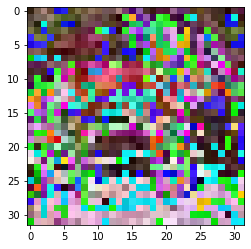

In [12]:
#commentout the normalization in cifar10 train data to see unnormalized img
img = next(iter(trainloader))[0][0]
plt.imshow(transforms.ToPILImage()(img))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 32, 32])


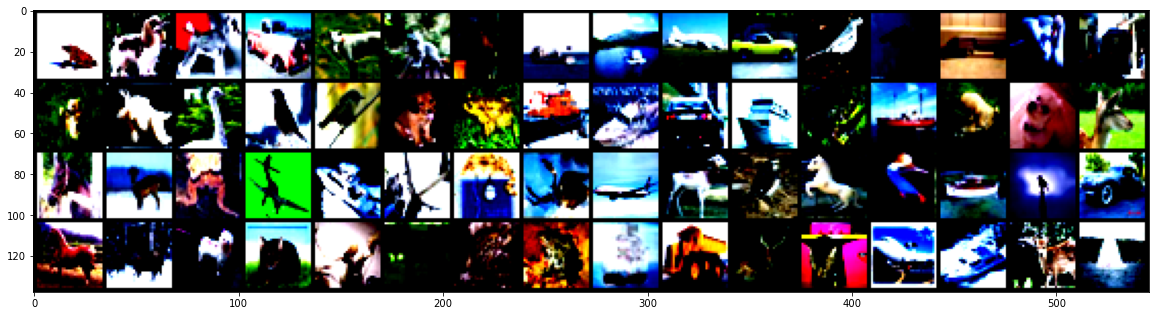

In [13]:
from torchvision.utils import make_grid
for images, _ in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 32, 32])


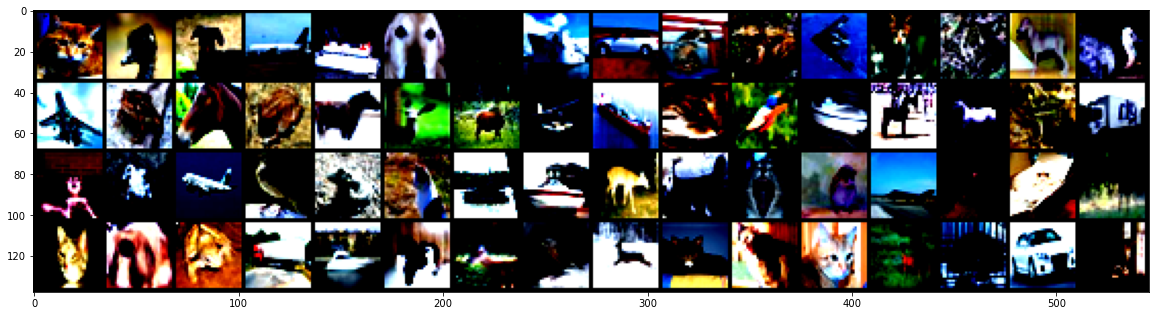

In [14]:
for images, _ in validloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 32, 32])


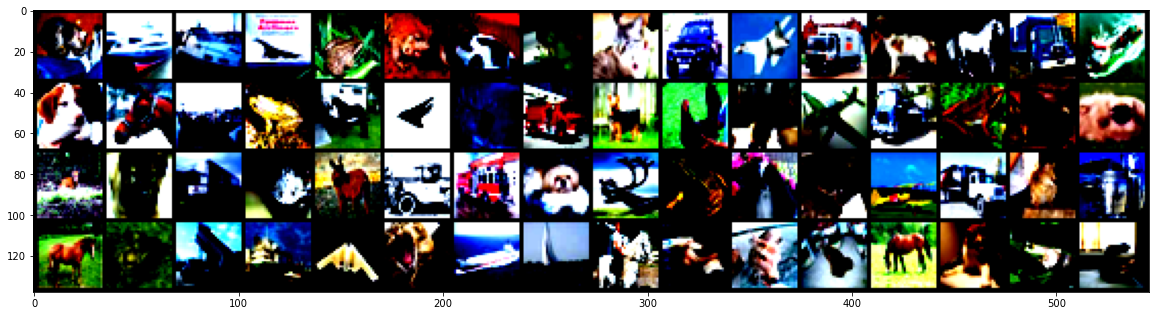

In [15]:
for images, _ in testloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [16]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device : {device}.")

Training on device : cuda.


In [17]:
class net(nn.Module): #take 32*32 input image and 73% validacc with lr=e4, bs=64, epoch=20
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1)
        self.fc1 = nn.Linear(2048, 1024) #512*2*2
        self.fc2 = nn.Linear(1024, 10)
        

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv4(out)), 2)

        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)

        return out



In [18]:
import datetime

def TrainingLoop (epoch, model, loss_fn, optimizer, trainloader ):
     for epoch in range(1, epoch+1):
         epoch_loss = 0
         for data, label in trainloader:
            data = data.to(device)
            label = label.to(device)
        
            output = model(data)
            loss = loss_fn(output, label)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss +=loss.item()
            
         if epoch == 1 or epoch %10 == 0:
            print(f"Loss in epoch {epoch} : {epoch_loss/len(trainloader)} : date and time : {datetime.datetime.now()}")
    
    
         with torch.no_grad():
              valid_loss = 0
              correct = 0
              total = 0
              for data, label in validloader:
                  data = data.to(device=device)
                  label = label.to(device=device)
            ## Forward Pass
                  val_output = model(data)
                  val_loss = loss_fn(val_output, label)
                  valid_loss += val_loss.item()
                  _, predicted = torch.max(val_output, dim=1)
                  total += label.shape[0]
                  correct += int((predicted == label).sum())
              if epoch == 1 or epoch %10 == 0:
               print(
                   f"Loss in Valid epoch {epoch} : {valid_loss/len(validloader)} : Got {correct} / {total} with valid accuracy of :{float(correct) / float(total) * 100:.2f}")

In [19]:
model = net().to(device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) 
loss_fn = nn.CrossEntropyLoss()


In [20]:

 
TrainingLoop(
      epoch = 20,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      trainloader = trainloader,
 )



Loss in epoch 1 : 1.615472078704834 : date and time : 2022-04-07 13:54:40.737261
Loss in Valid epoch 1 : 1.3344049575222525 : Got 5131 / 10000 with valid accuracy of :51.31
Loss in epoch 10 : 0.40106768094301226 : date and time : 2022-04-07 13:55:28.211234
Loss in Valid epoch 10 : 0.7627506531347894 : Got 7437 / 10000 with valid accuracy of :74.37
Loss in epoch 20 : 0.04557332959026098 : date and time : 2022-04-07 13:56:21.455193
Loss in Valid epoch 20 : 1.3071343177443098 : Got 7481 / 10000 with valid accuracy of :74.81


In [21]:
torch.save(model.state_dict(), "net_cifar10.pt") #save the model

In [22]:
model = net()
model.load_state_dict(torch.load("/CV_projects/cifar10/net_cifar10.pt"))
model.eval()

net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [23]:

total = 0
correct = 0

with torch.no_grad():
    for imgs, labels in testloader:
                imgs = imgs.to(device="cpu")
                labels = labels.to(device="cpu")
                output = model(imgs)
                _, predicted = torch.max(output, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
    print(
              f"Got {correct} / {total} with test accuracy {float(correct) / float(total) * 100:.2f}"
)


Got 7391 / 10000 with test accuracy 73.91
